::: {.callout-note collapse="true"}
## Learning Outcomes
- Use KDE for estimating density curve.
- Using transformations to analyze the relationship between two variables.
- Evalauting quality of a visualization based on visualization theory concepts.
:::

## Kernel Density Functions


### KDE Mechanics

In the last lecture, we learned that density curves are smooth, continuous functions that represent a distribution of values. In this section, we'll learn how to construct density curves using Kernel Density Estimation (KDE).

#### Smoothing

Kernel Density Estimation involves a technique called **smoothing** - a process applied to a distribution of values that allows us to analyze the more general structure of the dataset.

Many of the visualizations we learned during the last lecture are examples of smoothing. Histograms are smoothed versions of one-dimensional rug plots, and hex plots are smoother alternatives to two-dimensional scatter plots. They remove the detail from individual observations so we can visualize the larger properties of our distribution.

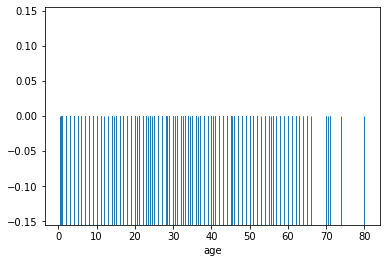

In [2]:
#| code-fold: true

import seaborn as sns

titanic = sns.load_dataset('titanic')
sns.rugplot(titanic['age'],height = 0.5);

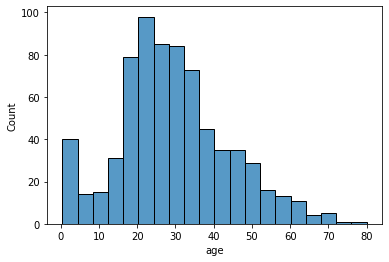

In [3]:
sns.histplot(titanic['age']);

#### Kernel Density Estimation

**Kernel Density Estimation** is a smoothing technique that allows us to estimate a density curve (also known as a probability density function) from a set of observations. There are a few steps in this process:

1. Place a kernel at each data point
2. Normalize kernels to have total area of 1 (across all kernels)
3. Sum kernels together

Suppose we have 5 data points: $[2.2, 2.8, 3.7, 5.3, 5.7]$. We wish to recreate the following Kernel Density Estimate:

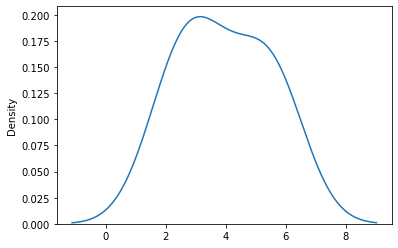

In [4]:
#| code-fold: true

data = [2.2, 2.8, 3.7, 5.3, 5.7]
sns.kdeplot(data);

Let's walk through each step to construct this density curve.

##### Step 1 - Place a Kernel at Each Data Point

To begin generating a density curve, we need to choose a **kernel** and **bandwidth value ($\alpha$)**. What are these exactly? A **kernel** is a density curve itself, and the **bandwidth ($\alpha$)** is a measure of the kernel's width. Recall that a valid density has an area of 1.

At each of our 5 points (depicted in the rug plot on the left), we've placed a Gaussian kernel with a bandwidth parameter of alpha = 1. We'll explore what these are in the next section.

:::: {.columns}

::: {.column width="30%"}
**Rugplot of Data**

<img src="images/rugplot_ex.png" alt='rugplot_ex' width='350'>
:::

::: {.column width="20%"}
<!-- empty column to create gap -->
:::

::: {.column width="30%"}
**Kernelized Data**

<img src="images/kde_step_1.png" alt='kde_step_1' width='360'>
:::

::::

##### Step 2 - Normalize Kernels to Have Total Area of 1

Notice how these 5 kernels are density curves - meaning they each have an area of 1. In Step 3, we will be summing each these kernels, and we want the result to be a valid density that has an area of 1. Therefore, it makes sense to normalize our current set of kernels by multiplying each by $\frac{1}{5}$.

:::: {.columns}

::: {.column width="30%"}
**Kernelized Data**

<img src="images/kde_step_1.png" alt='kde_step_1' width='350'>
:::

::: {.column width="20%"}
<!-- empty column to create gap -->
:::

::: {.column width="30%"}
**Normalized Kernels**

<img src="images/kde_step_2.png" alt='kde_step_2' width='345'>
:::

::::

##### Step 3 - Sum Kernels Together

Our kernel density estimate (KDE) is the sum of the normalized kernels along the x-axis. It is depicted below on the right.

:::: {.columns}

::: {.column width="30%"}
**Normalized Kernels**

<img src="images/kde_step_2.png" alt='kde_step_2' width='345'>
:::

::: {.column width="20%"}
<!-- empty column to create gap -->
:::

::: {.column width="30%"}
**Kernel Density Estimate**

<img src="images/kde_step_3.png" alt='kde_step_3' width='345'>
:::

::::

### Kernel Functions and Bandwidth

#### Kernels

A **kernel** (for our purposes) is a valid density function. This means it:

- Must be non-negative for all inputs.
- Must integrate to 1.

<img src= "./images/kde_function.png"></img>

A general “KDE formula” function is given above.

1. $K_{\alpha}(x, xi)$ is the kernel centered on the observation `i`. 
    - Each kernel individually has area 1.
    - x represents any number on the number line. It is the input to our function.
2. $n$ is the number of observed data points that we have.
    - We multiply by $\frac{1}{n}$ so that the total area of the KDE is still 1.
3. Each $x_i \in \{x_1, x_2, \dots, x_n\}$ represents an observed data point. 
    - These are what we use to create our KDE by summing multiple shifted kernels centered at these points.

\*$\alpha$ (alpha) is the bandwidth or smoothing parameter. 


##### Gaussian Kernel

The most common kernel is the **Gaussian kernel**. The Gaussian kernel is equivalent to the Gaussian probability density function (the Normal distribution), centered at the observed value $x_i$ with a standard deviation of $\alpha$ (this is known as the **bandwidth** parameter).

$K_a(x, x_i) = \frac{1}{\sqrt{2\pi\alpha^{2}}}e^{-\frac{(x-x_i)^{2}}{2\alpha^{2}}}$

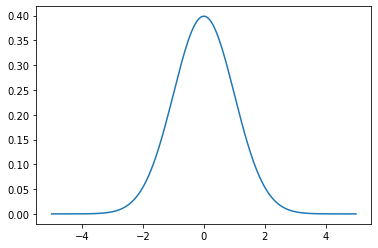

In [5]:
#| code-fold: true
#| fig-cap: The Gaussian kernel centered at 0 with bandwidth $\alpha$ = 1.

import numpy as np
import matplotlib.pyplot as plt 

def gaussian_kernel(alpha, x, z):
    return 1.0/np.sqrt(2. * np.pi * alpha**2) * np.exp(-(x - z) ** 2 / (2.0 * alpha**2))

xs = np.linspace(-5, 5, 200)
alpha = 1
kde_curve = [gaussian_kernel(alpha, x, 0) for x in xs]
plt.plot(xs, kde_curve);

If you've taken a probability class, you'll recognize that the mean of this Gaussian kernel is $x_i$ and the standard deviation is $\alpha$.  Increasing $\alpha$ - equivalently, the bandwidth - smoothens the density curve. Larger values of $\alpha$ are typically easier to understand; however, we begin to lose important distributional information. 

Here is how adjusting $\alpha$ affects a distribution in some variable from an arbitrary dataset.

:::: {.columns}

::: {.column width="30%"}
**Gaussian Kernel, $\alpha$ = 0.1**

<img src="images/gaussian_0.1.png" alt='gaussian_0.1' width='345'>
:::

::: {.column width="20%"}
<!-- empty column to create gap -->
:::

::: {.column width="30%"}
**Gaussian Kernel, $\alpha$ = 1**

<img src="images/gaussian_1.png" alt='gaussian_1' width='345'>
:::

::::

:::: {.columns}

::: {.column width="30%"}
**Gaussian Kernel, $\alpha$ = 2**

<img src="images/gaussian_2.png" alt='gaussian_2' width='345'>
:::

::: {.column width="20%"}
<!-- empty column to create gap -->
:::

::: {.column width="30%"}
**Gaussian Kernel, $\alpha$ = 10**

<img src="images/gaussian_10.png" alt='gaussian_10' width='345'>
:::

::::

##### Boxcar Kernel

Another example of a kernel is the **Boxcar kernel**. The boxcar kernel assigns a uniform density to points within a "window" of the observation, and a density of 0 elsewhere. The equation below is a Boxcar kernel with the center at $x_i$ and the bandwidth of $\alpha$.

$K_a(x, x_i) = \begin{cases}
        \frac{1}{\alpha}, & |x - x_i| \le \frac{\alpha}{2}\\
        0, & \text{else }
    \end{cases}$

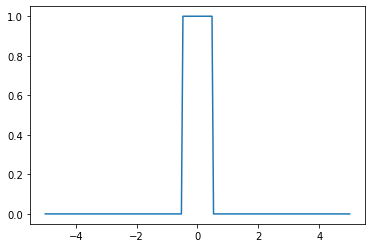

In [6]:
#| code-fold: true
#| fig-cap: The Boxcar kernel centered at 0 with bandwidth $\alpha$ = 1.

def boxcar_kernel(alpha, x, z):
    return (((x-z)>=-alpha/2)&((x-z)<=alpha/2))/alpha

xs = np.linspace(-5, 5, 200)
alpha=1
kde_curve = [boxcar_kernel(alpha, x, 0) for x in xs]
plt.plot(xs, kde_curve);

The diagram on the right is how the density curve for our 5 point dataset would have looked had we used the Boxcar kernel with bandwidth $\alpha$ = 1.

:::: {.columns}

::: {.column width="30%"}
<img src="images/gaussian_kernel.png" alt='kde_step_3' width='350'>
:::

::: {.column width="20%"}
<!-- empty column to create gap -->
:::

::: {.column width="30%"}
<img src="images/boxcar_kernel.png" alt='boxcar_kernel' width='350'>
:::

::::

### Relationships Between Quantitative Variables

Up until now, we've discussed how to visualize single-variable distributions. Going beyond this, we want to understand the relationship between pairs of numerical variables.

#### Scatter Plots

**Scatter plots** are one of the most useful tools in representing the relationship between two quantitative variables. They are particularly important in gauging the strength, or correlation between variables. Knowledge of these relationships can then motivate decisions in our modeling process.

For example, let's plot a scatter plot comparing the `Maternal Height` and `Birth Weight` colums, using both `matplotlib` and `seaborn`.

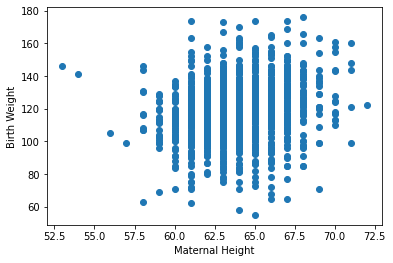

In [13]:
import pandas as pd
births = pd.read_csv("data/baby.csv")
births.head(5)

# Matplotlib Example
plt.scatter(births['Maternal Height'], births['Birth Weight'])
plt.xlabel('Maternal Height')
plt.ylabel('Birth Weight');

<AxesSubplot:xlabel='Maternal Height', ylabel='Birth Weight'>

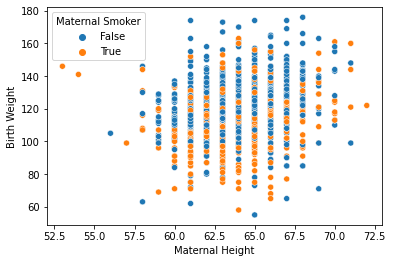

In [15]:
# Seaborn Example
sns.scatterplot(data = births, x = 'Maternal Height', y = 'Birth Weight',
                hue = 'Maternal Smoker')

This is an example where color is used to add a third dimension to our plot. This is possible with the `hue` paramater in `seaborn`, which adds a categorical column encoding to an existing visualization. This way, we can look for relationships in `Maternal Height` and `Birth Weight` in both maternal smokers and non-smokers. If we wish to see the relationship's strength more clearly, we can use `sns.lmplot`.

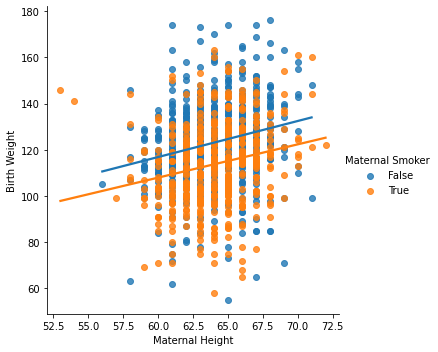

In [16]:
sns.lmplot(data = births, x = 'Maternal Height', y = 'Birth Weight', 
           hue = 'Maternal Smoker', ci = False);

We can make out a weak, positive relationship in the mother's height and birth weight for both maternal smokers and non-smokers (the baseline is slightly lower in maternal smokers).

### Overplotting

As you may have noticed, the scatterplots of `Maternal Height` vs. `Birth Weight` have many densely plotted areas. Many of the points are on top of one other! This makes it difficult to tell exactly how many babies are plotted in each the more densely populated regions of the graph. This can arise when the tools used for measuring data have low granularity, many different values are rounded to the same value, or if the ranges of the two variables differ greatly in scale.  

We can overcome this by introducing a small amount of uniform random noise to our data. This is called *jittering*. Let's see what happens when we introduce noise to the `Maternal Height`.


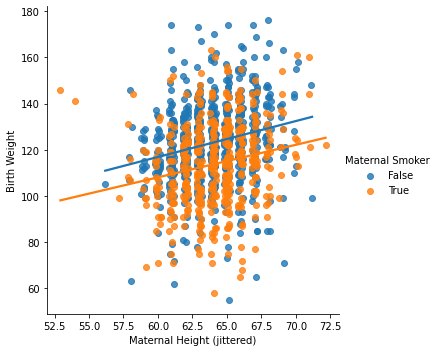

In [21]:
births["Maternal Height (jittered)"] = births["Maternal Height"] + np.random.uniform(-0.2, 0.2, len(births))
sns.lmplot(data = births, x = 'Maternal Height (jittered)', y = 'Birth Weight', 
           hue = 'Maternal Smoker', ci = False);

This plot more clearly shows that most of the data is clustered tightly around the point (62.5,120) and gradually becomes more loose further away from the center. It is much easier for us and others to see how the data is distributed. In conclusion, *jittering* helps us better understand our own data (Goal 1) and communicate results to others (Goal 2).  


#### Hex Plots and Contour Plots

Unfortunately, our scatter plots above suffered from overplotting, which made them hard to interpret. And with a large number of points, jittering is unlikely to resolve the issue. Instead, we can look to hex plots and contour plots.

**Hex Plots** can be thought of as a two dimensional histogram that shows the joint distribution between two variables. This is particularly useful working with very dense data. 

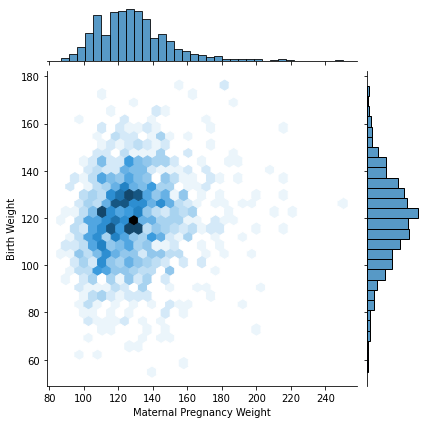

In [10]:
sns.jointplot(data = births, x = 'Maternal Pregnancy Weight', 
              y = 'Birth Weight', kind = 'hex')

The axes are evidently binned into hexagons, which makes the linear relationship easier to decipher. Darker regions generally indicate a higher density of points.

On the other hand, **contour plots** are two dimensional versions of density curves with marginal distributions of each variable on the axes. We've used very similar code here to generate our contour plots, with the addition of the `kind = 'kde'` and `fill = True` arguments.

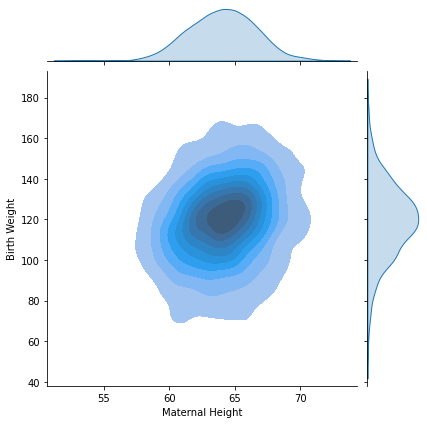

In [11]:
sns.jointplot(data = births, x = 'Maternal Height', y = 'Birth Weight',\
              kind = 'kde', fill = True)

## Transformations

These last two lectures have covered visualizations in great depth. We looked at various forms of visualizations, plotting libraries, and high-level theory.

Much of this was done to uncover insights in data, which will prove necessary for the modeling process. A strong graphical correlation between two variables hinted an underlying relationship that has reason for further study. However, relying on visual relationships alone is limiting - not all plots show association. The presence of outliers and other statistical anomalies make it hard to interpret data.

**Transformations** are the process of manipulating data to find significant relationships between variables. These are often found by applying mathematical functions to variables that "transform" their range of possible values and highlight some previously hidden associations between data.

#### Transforming a Distribution

When a distribution has a large dynamic range, it can be useful to take the logarithm of the data. For example, computing the logarithm of the ticket prices on the Titanic reduces skeweness and yields a distribution that is more "spread" across the x-axis. While it makes individual observations harder to interpret, the distribution is more favorable for subsequent analysis.

:::: {.columns}


::: {.column width="30%"}
<img src="images/untransformed_titanic.png" alt='untransformed_titanic' width='400'>
:::

::: {.column width="20%"}
<!-- empty column to create gap -->
:::

::: {.column width="30%"}
<img src="images/transformed_titanic.png" alt='transformed_titanic' width='400'>
:::

::::

#### Linearizing a Relationship

Transformations are perhaps most useful to **linearize a relationship** between variables. If we find a transformation to make a scatter plot of two variables linear, we can "backtrack" to find the exact relationship between the variables. Linear relationships are particularly simple to interpret, and we'll be doing a lot of linear modeling in Data 100 - starting next week!

Say we want to understand the relationship between healthcare and life expectancy. Intuitively there should be a positive correlation, but upon plotting values from a dataset, we find a non-linear relationship that is somewhat hard to understand. However, applying a logarithmic transformation to both variables - healthcare and life expectancy - results in a scatter plot with a linear trend that we can interpret.

:::: {.columns}


::: {.column width="30%"}
<img src="images/untransformed_healthcare_lifeexp.png" alt='untransformed_titanic' width='400'>
:::

::: {.column width="20%"}
<!-- empty column to create gap -->
:::

::: {.column width="30%"}
<img src="images/transformed_healthcare_lifeexp.png" alt='transformed_titanic' width='400'>
:::

::::

How can we find the relationship between the original variables? We know that taking a log of both axes gave us a linear relationship, so we can say (roughly) that 

$$\log y= a\times\log x + b$$

Solving for $y$ implies a **power** relationship in the original plot.

$$y= e^{a\times\log x + b}$$
$$y= Ce^{a\times\log x}$$
$$y= Cx^{a}$$

How did we know that taking the logarithm of both sides would result in a linear relationship? The **Tukey-Mosteller Bulge Diagram** is helpful here. We can use the direction of the buldge in our original data to find the appropriate transformations that will linearize the relationship. These transformations are found on axes that are nearest to the buldge. The buldge in our earlier example lay in Quadrant 2, so the transformations $\log x$, $\sqrt x$, $y^{2}$, or $y^{3}$ are possible contenders. It's important to note that this diagram is not perfect, and some transformations will work better than others. In our case, $\log x$ and $\log y$ (found in Quadrant 3) were the best.

<img src="images/tukey_mosteller.png" alt='tukey_mosteller' width='400'>

#### Additional Remarks

Visualization requires a lot of thought!
- There are many tools for visualizing distributions.
    - Distribution of a single variable:
        1. rug plot
        2. histogram
        3. density plot
        4. box plot
        5. violin plot
    - Joint distribution of two quantitative variables: 
        1. scatter plot
        2. hex plot
        3. contour plot.

This class primarily uses `seaborn` and `matplotlib`, but `Pandas` also has basic built-in plotting methods. Many other visualization libraries exist, and `plotly` is one of them.
- `plotly` creates very easily creates interactive plots.
- `plotly` will occasionally appear in lecture code, labs, and assignments! 

Next, we’ll go deeper into the theory behind visualization.


## Visualization Theory

This section marks a pivot to the second major topic of this lecture - visualization theory. We'll discuss the abstract nature of visualizations and analyze how they convey information.

Remember, we had two goals for visualizing data. This section is particularly important in:

1. Helping us understand the data and results
2. Communicating our results and conclusions with others

### Information Channels

Visualizations are able to convey information through various encodings. In the remainder of this lecture, we'll look at the use of color, scale, and depth, to name a few. 

#### Encodings in Rugplots

One detail that we may have overlooked in our earlier discussion of rugplots is the importance of encodings. Rugplots are effective visuals because they utilize line thickness to encode frequency. Consider the following diagram:

<img src="images/rugplot_encoding.png" alt='rugplot_encoding' width='600'> 

#### Multi-Dimensional Encodings

Encodings are also useful for representing multi-dimensional data. Notice how the following visual highlights four distinct "dimensions" of data:

- X-axis
- Y-axis
- Area
- Color

<img src="images/mutli_dim_encodings.png" alt='multi_dim_encoding' width='400'> 

The human visual perception sytem is only capable of visualizing data in a three-dimensional plane, but as you've seen, we can encode many more channels of information.

### Harnessing the Axes

#### Consider Scale of the Data

However, we should be careful to not misrepresent relationships in our data by manipulating the scale or axes. The visualization below improperly portrays two seemingly independent relationships on the same plot. The authors have clearly changed the scale of the y-axis to mislead their audience.

<img src="images/wrong_scale_viz.png" alt='wrong_scale_viz' width='350'> 

Notice how the downwards-facing line segment contains values in the millions, while the upwards-trending segment only contains values near three hundred thousand. These lines should not be intersecting.

When there is a large difference in the magnitude of the data, it's advised to analyze percentages instead of counts. The following diagrams correctly display the trends in cancer screening and abortion rates. 

:::: {.columns}


::: {.column width="30%"}
<img src="images/good_viz_scale_1.png" alt='good_viz_scale_1' width='345'>
:::

::: {.column width="20%"}
<!-- empty column to create gap -->
:::

::: {.column width="30%"}
<img src="images/good_viz_scale_2.png" alt='good_viz_scale_2' width='345'>
:::

::::

#### Reveal the Data

Great visualizations not only consider the scale of the data, but also utilize the axes in a way that best conveys information. For example, data scientists commonly set certain axes limits to highlight parts of the visualization they are most interested in.

:::: {.columns}


::: {.column width="30%"}
<img src="images/unrevealed_viz.png" alt='unrevealed_viz' width='345'>
:::

::: {.column width="20%"}
<!-- empty column to create gap -->
:::

::: {.column width="30%"}
<img src="images/revealed_viz.png" alt='revealed_viz' width='345'>
:::

::::

The visualization on the right captures the trend in coronavirus cases during the month March in 2020. From only looking at the visualization on the left, a viewer may incorrectly believe that coronavirus began to skyrocket on March 4^th^, 2020. However, the second illustration tells a different story - cases rose closer to March 21^th^, 2020.

### Harnessing Color

Color is another important feature in visualizations that does more than what meets the eye. 

Last lecture, we used color to encode a categorical variable in our scatter plot. In this section, we will discuss uses of color in novel visualizations like colormaps and heatmaps.

5-8% of the world is red-green color blind, so we have to be very particular about our color scheme. We want to make these as accessible as possible. Choosing a set of colors which work together is evidently a challenging task!

#### Colormaps

Colormaps are mappings from pixel data to color values, and they're often used to highlight distinct parts of an image. Let's investigate a few properties of colormaps.

:::: {.columns}


::: {.column width="30%"}
**Jet Colormap**
<img src="images/jet_colormap.png" alt='jet_colormap' width='250'>
:::

::: {.column width="20%"}
<!-- empty column to create gap -->
:::

::: {.column width="30%"}
**Viridis Colormap**
<img src="images/viridis_colormap.png" alt='viridis_colormap' width='250'>
:::

::::

The jet colormap is infamous for being misleading. While it seems more vibrant than viridis, the aggressive colors poorly encode numerical data. To understand why, let's analyze the following images.

:::: {.columns}


::: {.column width="30%"}
<img src="images/jet_four_by_four.png" alt='four_by_four_colormap' width='300'>
:::

::: {.column width="20%"}
<!-- empty column to create gap -->
:::

::: {.column width="30%"}
<img src="images/jet_3_images.png" alt='jet_3_colormap' width='250'>
:::

::::

The diagram on the left compares how a variety of colormaps represent pixel data that transitions from a high to low intensity. These include the jet colormap (row a) and grayscale (row b). Notice how the grayscale images do the best job in smoothly transitioning between pixel data. The jet colormap is the worst at this - the four images in row (a) look like a conglomeration of individual colors. 

The difference is also evident in the images labeled (a) and (b) on the left side. The grayscale image is better at preserving finer detail in the vertical line strokes. Additionally, grayscale is preferred in x-ray scans for being more neutral. The intensity of dark red color in the jet colormap is frightening and indicates something is wrong.

Why is the jet colormap so much worse? The answer lies in how its color composition is percieved to the human eye.

:::: {.columns}


::: {.column width="30%"}
**Jet Colormap Perception**
<img src="images/jet_perceptually_uniform.png" alt='jet_perceptually_uniform' width='300'>
:::

::: {.column width="20%"}
<!-- empty column to create gap -->
:::

::: {.column width="30%"}
**Viridis Colormap Perception**
<img src="images/viridis_perceptually_uniform.png" alt='viridis_perceptually_uniform' width='336'>
:::

::::

The jet colormap is largely misleading because it is not perceptually uniform. **Perceptually uniform colormaps** have the property that if the pixel data goes from 0.1 to 0.2, the perceptual change is the same as when the data goes from 0.8 to 0.9.

Notice how the said uniformity is present within the linear trend displayed in the viridis colormap. On the other hand, the jet colormap is largely non-linear - this is precisely why it's considered a worse colormap.

### Harnessing Markings

In our earlier discussion of multi-dimensional encodings, we analyzed a scatter plot with four pseudo-dimensions: the two axes, area, and color. Were these appropriate to use? The following diagram analyzes how well the human eye can distinguish between these "markings".

<img src="images/markings_viz.png" alt='markings_viz' width='300'>

There are a few key takeaways from this diagram

- Lengths are easy to discern. Don't use plots with jiggled baselines - keep everything axis-aligned.
- Avoid pie charts! Angle judgements are inaccurate.
- Areas and volumes are hard to distinguish (area charts, word clouds, etc)

### Harnessing Conditioning

Conditioning is the process of comparing data that belong to seperate groups. We've seen this before in overlayed distributions, side-by-side box-plots, and scatter plots with categorical encodings. Here, we'll introduce terminology that formalizes these examples.

Consider an example where we want to analyze income earnings for male and females with varying levels of education. There are multiple ways to compare this data. 

:::: {.columns}


::: {.column width="30%"}
<img src="images/male_female_earnings_barplot.png" alt='jet_perceptually_uniform' width='360'>
:::

::: {.column width="20%"}
<!-- empty column to create gap -->
:::

::: {.column width="30%"}
<img src="images/male_female_earnings_scatterplot.png" alt='viridis_perceptually_uniform' width='340'>
:::

::::

The barplot is an example of **juxtaposition**: placing multiple plots side by side, with the same scale. The scatter plot is an example of **superposition**: placing multiple density curves, scatter plots on top of each other. 

Which is better depends on the problem at hand. Here, superposition makes the precise wage difference very clear from a quick glance. But many sophisticated plots convey information that favors the use of juxtaposition. Below is one example.

<img src="images/small_multiples.png" alt='small_multiples' width='600'>
                                                        

### Harnessing Context

The last component to a great visualization is perhaps the most critical - the use of context. Adding informative titles, axis labels, and descriptive captions are all best practices that we've heard repeatedly in Data 8.

A publication-ready plot (and every Data 100 plot) needs:

- Informative title (takeaway, not description)
- Axis labels
- Reference lines, markers, etc
- Legends, if appropriate
- Captions that describe data

Captions should be:

- Comprehensive and self-contained
- Describe what has been graphed
- Draw attention to important features
- Describe conclusions drawn from graphs
